# QF605 Fixed-Income Securities
## Part 3 - Convexity Correction
#### Prepared by: Zhang Shuxin, Jiang Shuang, Ong Shi Xin, Victor Kow, Wang Bo, Ankit Rawat, Sun Jianyun

In [42]:
import numpy as np
import pandas as pd
from scipy.stats import norm
from scipy.integrate import quad
import matplotlib.pylab as plt

import warnings
warnings.filterwarnings("ignore")

In [43]:
def Black76Call(S, K, disc, sigma, T):
    d1 = (np.log(S/K)+sigma**2/2*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return disc*(S*norm.cdf(d1) - K*norm.cdf(d2))

def Black76Put(S, K, disc, sigma, T):
    d1 = (np.log(S/K)+sigma**2/2*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return disc*(K*norm.cdf(-d2) - S*norm.cdf(-d1))

def SABR(F, K, T, alpha, beta, rho, nu):
    X = K
    # if K is at-the-money-forward
    if abs(F - K) < 1e-12:
        numer1 = (((1 - beta)**2)/24)*alpha*alpha/(F**(2 - 2*beta))
        numer2 = 0.25*rho*beta*nu*alpha/(F**(1 - beta))
        numer3 = ((2 - 3*rho*rho)/24)*nu*nu
        VolAtm = alpha*(1 + (numer1 + numer2 + numer3)*T)/(F**(1-beta))
        sabrsigma = VolAtm
    else:
        z = (nu/alpha)*((F*X)**(0.5*(1-beta)))*log(F/X)
        zhi = log((((1 - 2*rho*z + z*z)**0.5) + z - rho)/(1 - rho))
        numer1 = (((1 - beta)**2)/24)*((alpha*alpha)/((F*X)**(1 - beta)))
        numer2 = 0.25*rho*beta*nu*alpha/((F*X)**((1 - beta)/2))
        numer3 = ((2 - 3*rho*rho)/24)*nu*nu
        numer = alpha*(1 + (numer1 + numer2 + numer3)*T)*z
        denom1 = ((1 - beta)**2/24)*(log(F/X))**2
        denom2 = (((1 - beta)**4)/1920)*((log(F/X))**4)
        denom = ((F*X)**((1 - beta)/2))*(1 + denom1 + denom2)*zhi
        sabrsigma = numer/denom

    return sabrsigma

In [44]:
def IRR(x,N,m):
    IRR=np.zeros(N*m)
    IRRS=0
    for i in range(N*m):
        IRR[i]= 1/m / (1+x/m)**i
    IRRS=np.sum(IRR[:])
    return IRRS

def IRRf(x,N,m):
    dx = 0.05 * x
    IRRplus= IRR(x+dx,N,m)
    IRRminus = IRR (x-dx,N,m)
    IRRf = (IRRplus - IRRminus) / (2*dx)
    return IRRf

def IRRff(x,N,m):
    dx = 0.05 * x
    IRRplus= IRR(x+dx,N,m)
    IRRx = IRR(x,N,m)
    IRRminus = IRR (x-dx,N,m)
    IRRff = (IRRplus - 2*IRRx + IRRminus) / (dx**2)
    return IRRff

def hff(x, N, m, F, sigma, T):
    h = (-IRRff(x,N,m) * x - 2 * IRRf(x,N,m) ) / (IRR(x,N,m)**2) +\
        2 * IRRf(x,N,m)**2 * x / IRR(x,N,m)**3
    return h

def integral1(x,N,m,F,disc,sigma,T):
    h = hff(x, N, m, F, sigma, T)
    Vrec = Black76Put(F, x, disc,sigma, T)
    return h*Vrec

def integral2(x,N,m,F,disc,sigma,T):
    h = hff(x, N, m, F, sigma, T)
    Vpay = Black76Call(F, x, disc,sigma, T)
    return h*Vpay

### 2. CMS Rate Calculation

In [45]:
alpha = pd.read_csv('sabr_alpha.csv', header = 0, index_col = 0 )
rho = pd.read_csv('sabr_rho.csv', header = 0, index_col = 0)
nu = pd.read_csv('sabr_nu.csv', header = 0, index_col = 0)

In [46]:
fsr = pd.read_csv('forward_swap_rate.csv', header = 0, index_col = 0)

In [47]:
Expiry = ['1Y','5Y','10Y']
Tenor = ['1Y','2Y','3Y','5Y','10Y']

In [48]:
CMS_Rate=pd.DataFrame(np.zeros((3,5)),index=Expiry,columns=Tenor)

In [49]:
for ex in Expiry:
    for te in Tenor:
        F = fsr.loc[ex, te]
        T = int(ex.strip()[:-1])
        ex_int = int(ex.strip()[:-1])
        te_int = int(te.strip()[:-1])
        N = ex_int + te_int
        sigma = SABR(F, F, T, alpha.loc[ex, te], 0.9, rho.loc[ex, te], nu.loc[ex,te])
        term1 = quad(lambda x:integral1(x,N,1,F,IRR(F, N, 1), sigma, T),0,F)
        term2 = quad(lambda x:integral2(x,N,1,F,IRR(F, N, 1), sigma, T),F,np.inf)
        
        CMS_Rate.loc[ex,te] = F + np.sum(term1 + term2)

In [50]:
CMS_Rate

,1Y,2Y,3Y,5Y,10Y
1Y,0.032029,0.033345,0.034158,0.035458,0.038848
5Y,0.040797,0.042536,0.043012,0.044087,0.047919
10Y,0.052270,0.055583,0.058432,0.060288,0.071961


In [51]:
# compare with the forward swap rate
FW_rate = pd.read_csv('forward_swap_rate.csv', header = 0, index_col = 0)
FW_rate

,1Y,2Y,3Y,5Y,10Y
1Y,0.032007,0.033259,0.034011,0.035255,0.038428
5Y,0.039274,0.040075,0.040072,0.041093,0.043634
10Y,0.042189,0.043116,0.044097,0.046249,0.053458


In [52]:
# check the difference
comparison = []
for x in Expiry:
    for y in Tenor:
        rate_diff =  CMS_Rate.loc[x,y] - FW_rate.loc[x,y]
        comparison.append(rate_diff)

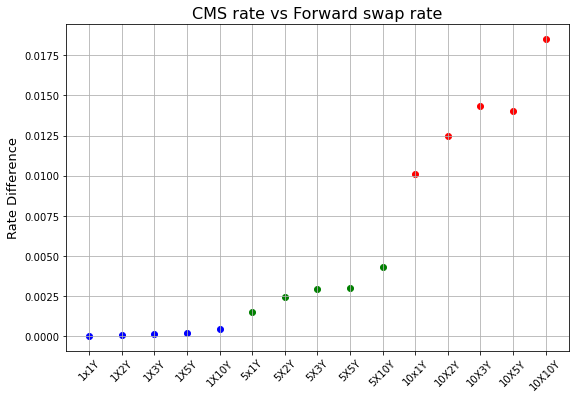

In [53]:
plt.figure(figsize = (9, 6))
plt.scatter(['1x1Y', '1X2Y', '1X3Y', '1X5Y', '1X10Y'], comparison[:5], c = 'b')
plt.scatter(['5x1Y', '5X2Y', '5X3Y', '5X5Y', '5X10Y'], comparison[5:10], c = 'g')
plt.scatter(['10x1Y', '10X2Y', '10X3Y', '10X5Y', '10X10Y'], comparison[10:], c = 'r')
plt.grid()
plt.xticks(rotation = 45)
plt.title('CMS rate vs Forward swap rate', fontsize = 16)
plt.ylabel('Rate Difference', fontsize = 13);

### 1.1 PV of a leg receiving CMS10y semi-annually over the next 5 years

In [54]:
dis = pd.read_csv('discount_factor.csv', header = 0)

In [55]:
start = ['0.5Y', '1Y', '1.5Y', '2Y', '2.5Y', '3Y', '3.5Y',
        '4Y', '4.5Y', '5Y']
tenor = ['10Y']

In [56]:
# get the forward swap rate for different expiry X tenor 
forward = []
for ex in start:
    for te in tenor:
        i = float(ex.strip()[:-1])
        j = float(te.strip()[:-1])
        deno = 0.5*sum(dis.OIS_DF[int(2*i):int(2*(i+j))])
        
        terms = []
        for x in range(int(2*i), int(2*(i+j))):
            no = dis.OIS_DF[x] * (dis.Libor_DF[x-1] - dis.Libor_DF[x])/dis.Libor_DF[x]
            terms.append(no)
        numer = sum(terms)
        
        forward.append(numer/deno)

In [57]:
data = pd.DataFrame({'Start': start, 'Tenor':tenor * 10, 
              'FS' : forward,
              'DF' : dis.OIS_DF[:10],
              'alpha': np.NaN,
              'rho': np.NaN,
              'nu': np.NaN})
data

,Start,Tenor,FS,DF,alpha,rho,nu
0,0.5Y,10Y,0.037845,0.998752,NaN,NaN,NaN
1,1Y,10Y,0.038428,0.997009,NaN,NaN,NaN
2,1.5Y,10Y,0.039020,0.995270,NaN,NaN,NaN
3,2Y,10Y,0.039634,0.993531,NaN,NaN,NaN
4,2.5Y,10Y,0.040200,0.991773,NaN,NaN,NaN
5,3Y,10Y,0.040788,0.990015,NaN,NaN,NaN
6,3.5Y,10Y,0.041412,0.988066,NaN,NaN,NaN
7,4Y,10Y,0.042062,0.986117,NaN,NaN,NaN
8,4.5Y,10Y,0.042831,0.984150,NaN,NaN,NaN
9,5Y,10Y,0.043634,0.982184,NaN,NaN,NaN


In [58]:
# plug the known alpha, rho, nu  and then interpolate
data.iloc[1,4] = 0.171130
data.iloc[9,4] = 0.176437
data.iloc[1,5] = -0.264831
data.iloc[9,5] = -0.440701
data.iloc[1,6] = 0.777658
data.iloc[9,6] = 0.494010

In [59]:
data['alpha'] = data.alpha.interpolate(limit_direction = 'both')

In [60]:
data['nu'] = data.nu.interpolate(limit_direction = 'both')
data['rho'] = data.rho.interpolate(limit_direction = 'both')

In [61]:
data['CMS'] = np.NaN

In [62]:
# get thte CMS rate 
for i in range(0, 10):
    F = data.FS[i]
    T = (i+1)/2
    N = 5
    m = 2 #semi-annually
    sigma = SABR(F, F, T, data.alpha[i], 0.9, data.rho[i],data.nu[i] )
    term1 = quad(lambda x:integral1(x,N,m,F,IRR(F, N, m), sigma, T),0,F)
    term2 = quad(lambda x:integral2(x,N,m,F,IRR(F, N, m), sigma, T),F,np.inf)
        
    data.CMS[i] = F + np.sum(term1 + term2)

In [63]:
data

,Start,Tenor,FS,DF,alpha,rho,nu,CMS
0,0.5Y,10Y,0.037845,0.998752,0.171130,-0.264831,0.777658,0.037936
1,1Y,10Y,0.038428,0.997009,0.171130,-0.264831,0.777658,0.038626
2,1.5Y,10Y,0.039020,0.995270,0.171793,-0.286815,0.742202,0.039338
3,2Y,10Y,0.039634,0.993531,0.172457,-0.308798,0.706746,0.040086
4,2.5Y,10Y,0.040200,0.991773,0.173120,-0.330782,0.671290,0.040795
5,3Y,10Y,0.040788,0.990015,0.173784,-0.352766,0.635834,0.041535
6,3.5Y,10Y,0.041412,0.988066,0.174447,-0.374750,0.600378,0.042319
7,4Y,10Y,0.042062,0.986117,0.175110,-0.396734,0.564922,0.043137
8,4.5Y,10Y,0.042831,0.984150,0.175774,-0.418717,0.529466,0.044086
9,5Y,10Y,0.043634,0.982184,0.176437,-0.440701,0.494010,0.045077


In [64]:
# PV of a leg receiving CMS10y semi-annually over the next 5 years 

PV = []
for i in range(0, 10):
    PV.append(0.5 * data.DF[i] * data.CMS[i])
sum(PV)

0.2044855759008284

In [65]:
data.to_csv('CMS_10Y.csv')

### 1.2 PV of a leg receiving CMS2y quarterly over the next 10 years

In [66]:
data2 = pd.DataFrame(np.zeros((50,3)),columns=['Tenor','OIS_DF', 'Libor_DF'])
data2['Tenor'] = np.linspace(0.25, 12.5, 50 )
data2['OIS_DF'] = np.NaN
data2['Libor_DF'] = np.NaN

In [67]:
dis2 = dis.set_index('Tenor')

In [68]:
data2 = data2.set_index('Tenor')

In [69]:
data2['OIS_DF'] = dis2['OIS_DF']
data2['Libor_DF'] = dis2['Libor_DF']

In [70]:
data2['OIS_DF'] = data2['OIS_DF'].interpolate(limit_direction = 'both')
data2['Libor_DF'] = data2['Libor_DF'].interpolate(limit_direction = 'both')

In [71]:
data3 = data2.reset_index()
data3

,Tenor,OIS_DF,Libor_DF
0,0.25,0.998752,0.987654
1,0.50,0.998752,0.987654
2,0.75,0.997880,0.980116
3,1.00,0.997009,0.972577
4,1.25,0.996139,0.964977
5,1.50,0.995270,0.957378
6,1.75,0.994400,0.949778
7,2.00,0.993531,0.942179
8,2.25,0.992652,0.934255
9,2.50,0.991773,0.926330


In [72]:
start2 = np.linspace(0.25, 10, 40)
tenor2 = [2]

In [73]:
forward2 = []
for i in start2:
    for j in tenor2:
       
        deno = 0.25*sum(data3.OIS_DF[int(4*i):int(4*(i+j))])
        
        terms = []
        for x in range(int(4*i), int(4*(i+j))):
            no = data3.OIS_DF[x] * (data3.Libor_DF[x-1] - data3.Libor_DF[x])/data3.Libor_DF[x]
            terms.append(no)
        numer = sum(terms)
        
        forward2.append(numer/deno)

In [74]:
da = data3.iloc[:40, :]

In [75]:
da['FS'] = forward2

In [76]:
da['alpha'] = np.NaN
da['rho'] = np.NaN
da['nu'] = np.NaN

In [77]:
da.iloc[3, 4] = 0.184648
da.iloc[19, 4] = 0.199502
da.iloc[39, 4] = 0.195225
da.iloc[3, 5] = -0.525117
da.iloc[19, 5] = -0.546903
da.iloc[39, 5] = -0.544353
da.iloc[3, 6] = 1.677418
da.iloc[19, 6] = 1.061927
da.iloc[39, 6] = 0.925449

In [78]:
da.alpha = da.alpha.interpolate(limit_direction = 'both')
da.rho = da.alpha.interpolate(limit_direction = 'both')
da.nu = da.nu.interpolate(limit_direction = 'both')

In [79]:
da['CMS'] = np.NaN

In [80]:
for i in range(0, 40):
    F = da.FS[i]
    T = (i+1)/4
    N = 10
    m = 4
    sigma = SABR(F, F, T, da.alpha[i], 0.9, da.rho[i],da.nu[i] )
    term1 = quad(lambda x:integral1(x,N,m,F,IRR(F, N, m), sigma, T),0,F)
    term2 = quad(lambda x:integral2(x,N,m,F,IRR(F, N, m), sigma, T),F,np.inf)
        
    da.CMS[i] = F + np.sum(term1 + term2)

In [81]:
# PV of a leg receiving CMS2y quarterly over the next 10 years 
PV = []
for i in range(0, 40):
    PV.append(0.25 * da.OIS_DF[i] * da.CMS[i])
sum(PV)

0.5826853992292426

In [41]:
#exit()